In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys

sys.path.append("..")
sys.path.append("../..")

from cge_modeling import Variable, Parameter, Equation, CGEModel
from cge_modeling.pytensorf.compile import (
    compile_cge_model_to_pytensor,
    euler_approximation_from_CGEModel,
    pytensor_objects_from_CGEModel,
)
from cge_modeling.base.utilities import variable_dict_to_flat_array, flat_array_to_variable_dict

In [2]:
from itertools import chain

In [18]:
sectors = ["Ag", "Ind", "Serv"]
n_sectors = len(sectors)
coords = {"i": sectors, "j": sectors}

In [19]:
variable_info = [
    Variable(name="Y", dims="i", description="Total output of good <dim:i>"),
    # Firm
    Variable(name="VA", dims="i", description="Labor-capital bundle produced by sector <dim:i>"),
    Variable(
        name="VC", dims="i", description="Intermediate goods bundle produced by sector <dim:i>"
    ),
    Variable(
        name="X",
        dims=("i", "j"),
        description="Demand for sector <dim:i> goods by sector <dim:j>",
    ),
    # Factor demands
    Variable(
        name="L_d",
        dims="i",
        extend_subscript=True,
        description="Labor demanded by sector <dim:i>",
    ),
    Variable(
        name="K_d",
        dims="i",
        extend_subscript=True,
        description="Capital demanded by sector <dim:i>",
    ),
    Variable(
        name="KE_d",
        dims="i",
        extend_subscript=True,
        description="Capital Energy bundle demanded by sector <dim:i>",
    ),
    Variable(
        name="E_d",
        dims="i",
        extend_subscript=True,
        description="Energy demanded by sector <dim:i>",
    ),
    # Household Variables
    Variable(name="U", description="Household utility"),
    Variable(name="C", dims="i", description="Household consumption of good <dim:i>"),
    Variable(name="C_total", description="Household overall consumption"),
    Variable(name="income", latex_name="Omega", description="Total household income"),
    # Factor supply
    Variable(
        name="L_s",
        description="Labor supply by households",
    ),
    # Prices
    Variable(name="r", description="Rental rate of capital"),
    Variable(name="w", description="Wage level"),
    Variable(
        name="P_VA",
        dims="i",
        extend_subscript=True,
        description="Price of the labor-capital bundle in sector <dim:i>",
    ),
    Variable(
        name="P_VC",
        dims="i",
        extend_subscript=True,
        description="Price of the intermediate bundle in sector <dim:i>",
    ),
    Variable(name="P", dims="i", description="Price level of final goods in sector <dim:i>"),
    Variable(
        name="P_KE",
        dims="i",
        extend_subscript=True,
        description="Price of the intermediate capital energy bundle in sector <dim:i>",
    ),
    Variable(
        name="P_E",
        description="Price of the energy bundle",
    ),
    Variable(name="CPI", description="Consumer price index"),
    # Other
    Variable(name="resid", latex_name=r"varepsilon", description="Walrasian residual"),
]

param_info = [
    # Firm Parameters
    Parameter(
        name="psi_VA",
        extend_subscript=True,
        dims="i",
        description="Share of labor-capital in sector <dim:i>'s final good",
    ),
    Parameter(
        name="psi_VC",
        extend_subscript=True,
        dims="i",
        description="Share of intermediate goods bundle in sector <dim:i>'s final product",
    ),
    Parameter(
        name="psi_X",
        extend_subscript=True,
        dims=("i", "j"),
        description="Share of sector <dim:i>'s final good in sector <dim:j>'s value chain bundle",
    ),
    Parameter(
        name="alpha_VA",
        dims="i",
        description="Share of capital energy bundle in sector <dim:i>'s production process",
    ),
    Parameter(
        name="alpha_KE",
        dims="i",
        description="Share of capital in capital energy bundle in sector <dim:i>'s production process",
    ),
    Parameter(
        name="alpha_C",
        dims="i",
        description="Consumption aggregation",
    ),
    Parameter(
        name="phi_VA",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> sector VA bundle",
    ),
    Parameter(
        name="phi_KE",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> sector KE bundle",
    ),
    Parameter(name="A", dims="i", description="Total factor productivity in sector <dim:i>"),
    Parameter(
        name="A_KE",
        dims="i",
        description="Total factor productivity in capital energy bundle <dim:i>",
    ),
    Parameter(name="A_C", description="Consumption aggregation"),
    # Household
    Parameter(name="epsilon_C", description="Consumption elasticity of substitution"),
    Parameter(name="sigma_C", description="Consumption elasticity of substitution"),
    Parameter(name="sigma_L", description="Labour elasticity of substitution"),
    Parameter(name="Theta", description="Household labor dispreference parameter"),
    # Exogenous variables
    # Parameter(name="L_s", description="Exogenous household labor supply"),
    Parameter(name="K_s", description="Exogenous household capital stock"),
    Parameter(
        name="P_Ag_bar",
        latex_name=r"\bar{P}_{Ag}",
        description="Exogenous agricultural price level",
    ),
    Parameter(name="E_s", description="Exogenous energy endwoment"),
]

equations = [
    # Final Goods
    Equation("Final good production of sector <dim:i>", "P * Y = P_VC * VC + P_VA * VA"),
    Equation("Sector <dim:i> demand for intermediate goods bundle", "VC = psi_VC * Y"),
    Equation("Sector <dim:i> demand for labor-capital", "VA = psi_VA * Y"),
    # Value chain bundle
    Equation(
        "Sector <dim:i> production of intermediate goods bundle",
        "VC * P_VC = Sum(P.subs({i:j}) * X.subs([(i,k), (j,i), (k,j)]), "
        + f"(j, 0, {n_sectors - 1}))",
    ),
    Equation(
        "Sector <dim:i> demand for sector <dim:j> intermediate input",
        "X = psi_X * VC.subs({i:j})",
    ),
    # Value add bundle
    Equation(
        "Sector <dim:i> production of labor and capital energy bundle",
        "VA = A * (alpha_VA * KE_d**((phi_VA - 1) / phi_VA) +"
        "(1 - alpha_VA) * L_d**((phi_VA - 1) / phi_VA)) ** (phi_VA / (phi_VA - 1))",
    ),
    # Sector Firms
    Equation(
        "Sector <dim:i> demand for capital energy bundle",
        "KE_d = VA / A * (alpha_VA * P_VA * A / P_KE) ** phi_VA",
    ),
    Equation(
        "Sector <dim:i> demand for labor",
        "L_d = VA / A * ((1 - alpha_VA) * A * P_VA / w) ** phi_VA",
    ),
    Equation(
        "Setor <dim:i> production of capital and energy",
        "KE_d = A_KE * (alpha_KE * K_d ** ((phi_KE - 1) / phi_KE) +"
        "(1 - alpha_KE) * E_d **((phi_KE - 1) / phi_KE)) ** (phi_KE / (phi_KE - 1))",
    ),
    Equation(
        "Sector <dim:i> demand for captial",
        "K_d = KE_d / A_KE * (alpha_KE * P_KE / r * A_KE) ** phi_KE",
    ),
    Equation(
        "Sector <dim:i> demand for energy",
        "E_d = KE_d / A_KE * ((1 - alpha_KE) * P_KE / P_E * A_KE) ** phi_KE",
    ),
    # Household Equations
    Equation(
        "Household income",
        "income = w * L_s + r * K_s + P_E * E_s",
    ),
    Equation(
        "Household utility",
        "U = C_total ** (1 - sigma_C) / (1 - sigma_C) - Theta * L_s ** (1 + sigma_L) / (1 + sigma_L)",
    ),
    Equation(
        "Consumption aggregator",
        "C_total = A_C * Sum(alpha_C * C**((epsilon_C-1) /epsilon_C), "
        + f"(i, 0, {n_sectors-1})) ** (epsilon_C / (epsilon_C - 1))",
    ),
    Equation(
        "Household demand for good <dim:i>",
        "C = C_total / A_C * (alpha_C * A_C * CPI / P) ** epsilon_C",
    ),
    Equation(
        "Household supply of labor",
        "L_s ** sigma_L * C_total ** sigma_C = w / Theta",
    ),
    # Market clearning conditions
    Equation("Labour market clearing", "L_s = Sum(L_d, " + f"(i, 0, {n_sectors - 1})) + resid"),
    Equation("Capital market clearing", f"K_s = Sum(K_d, (i, 0, {n_sectors - 1}))"),
    Equation(
        "Energy market clearing",
        f"E_s = Sum(E_d, (i, 0, {n_sectors - 1}))",
    ),
    Equation("Sector <dim:i> goods market clearing", f"Y = C + Sum(X, (j, 0, {n_sectors - 1}))"),
    Equation("Numeraire", "CPI = P_Ag_bar"),
    Equation(
        "CPI level",
        "1 = Sum(alpha_C * P ** (1 - epsilon_C), " + f"(i, 0, {n_sectors-1}))",
    ),
]

In [20]:
mod = CGEModel(
    variables=variable_info,
    parameters=param_info,
    equations=equations,
    coords=coords,
    parse_equations_to_sympy=True,  # True
    backend="numba",  # numba
    # mode=None, # no mode
    compile=True,
)

In [21]:
mod.n_variables

54

In [22]:
len(mod.unpacked_equation_names)

54

In [23]:
for i in mod.unpacked_equations:
    display(i)

Final good production of sector Ag

Final good production of sector Ind

Final good production of sector Serv

Sector Ag demand for intermediate goods bundle

Sector Ind demand for intermediate goods bundle

Sector Serv demand for intermediate goods bundle

Sector Ag demand for labor-capital

Sector Ind demand for labor-capital

Sector Serv demand for labor-capital

Sector Ag production of intermediate goods bundle

Sector Ind production of intermediate goods bundle

Sector Serv production of intermediate goods bundle

Sector Ag demand for sector Ag intermediate input

Sector Ag demand for sector Ind intermediate input

Sector Ag demand for sector Serv intermediate input

Sector Ind demand for sector Ag intermediate input

Sector Ind demand for sector Ind intermediate input

Sector Ind demand for sector Serv intermediate input

Sector Serv demand for sector Ag intermediate input

Sector Serv demand for sector Ind intermediate input

Sector Serv demand for sector Serv intermediate input

Sector Ag production of labor and capital energy bundle

Sector Ind production of labor and capital energy bundle

Sector Serv production of labor and capital energy bundle

Sector Ag demand for capital energy bundle

Sector Ind demand for capital energy bundle

Sector Serv demand for capital energy bundle

Sector Ag demand for labor

Sector Ind demand for labor

Sector Serv demand for labor

Setor Ag production of capital and energy

Setor Ind production of capital and energy

Setor Serv production of capital and energy

Sector Ag demand for captial

Sector Ind demand for captial

Sector Serv demand for captial

Sector Ag demand for energy

Sector Ind demand for energy

Sector Serv demand for energy

Household income

Household utility

Consumption aggregator

Household demand for good Ag

Household demand for good Ind

Household demand for good Serv

Household supply of labor

Labour market clearing

Capital market clearing

Energy market clearing

Sector Ag goods market clearing

Sector Ind goods market clearing

Sector Serv goods market clearing

Numeraire

CPI level

In [9]:
data = np.array(
    [
        [0, 0, 0, 0, 1000, 2000, 4000, 10],
        [0, 0, 0, 0, 500, 1000, 500, 2000],
        [0, 0, 0, 0, 1000, 1000, 1000, 500],
        [7010, 4000, 3500, 0, 0, 0, 0, 0],
        [0, 0, 0, 3000, 1000, 1000, 1000, 500],
        [0, 0, 0, 3000, 2000, 3500, 2000, 2000],
        [0, 0, 0, 5500, 500, 2500, 1000, 500],
        [0, 0, 0, 3010, 500, 1500, 500, 0],
    ]
)

df = pd.DataFrame(data)
cols = ["L_d", "K_d", "E_d", "Men", *sectors]

df = df.iloc[: len(cols), : len(cols)]
df.columns = cols
df.index = cols

In [10]:
df

,L_d,K_d,E_d,Men,Ag,Ind,Serv,Utility
L_d,0,0,0,0,1000,2000,4000,10
K_d,0,0,0,0,500,1000,500,2000
E_d,0,0,0,0,1000,1000,1000,500
Men,7010,4000,3500,0,0,0,0,0
Ag,0,0,0,3000,1000,1000,1000,500
Ind,0,0,0,3000,2000,3500,2000,2000
Serv,0,0,0,5500,500,2500,1000,500
Utility,0,0,0,3010,500,1500,500,0


In [11]:
df.sum(axis=0) - df.sum(axis=1)

L_d        0
K_d        0
E_d        0
Men        0
Ag         0
Ind        0
Serv       0
Utility    0
dtype: int64

In [12]:
data = {
    "L_d": df.loc["L_d", sectors].values,
    "K_d": df.loc["K_d", sectors].values,
    "E_d": df.loc["E_d", sectors].values,
    "X": df.loc[sectors, sectors].values,
    "Y": df.loc[sectors, :].values.sum(axis=1),
    "C": df.loc[sectors, "Men"].values,
    "phi_VA": np.full(n_sectors, 3.0),
    "phi_KE": np.full(n_sectors, 2.0),
    "epsilon_C": 2,
    "sigma_C": 2,
    "Theta": 1e-8,
    "r": 1.0,
    "w": 1.0,
    "P_E": 1.0,
    "P_Ag_bar": 1.0,
    "CPI": 1.0,
    "P": np.ones((n_sectors,)),
    "P_VA": np.ones((n_sectors,)),
    "P_VC": np.ones((n_sectors,)),
    "P_KE": np.ones((n_sectors,)),
}

In [13]:
def calibrate_model(
    L_d,
    K_d,
    E_d,
    X,
    Y,
    C,
    phi_VA,
    phi_KE,
    epsilon_C,
    sigma_C,
    Theta,
    r,
    w,
    P,
    P_Ag_bar,
    P_VA,
    P_VC,
    P_E,
    P_KE,
    CPI,
):
    calib_dict = {}

    # rho
    _rho_VA = (phi_VA - 1) / phi_VA
    _rho_KE = (phi_KE - 1) / phi_KE
    _rho_C = (epsilon_C - 1) / epsilon_C

    # Numeraire
    resid = 0.0

    # Household calibration
    L_s = L_d.sum()
    K_s = K_d.sum()
    E_s = E_d.sum()

    income = w * L_s + r * K_s + P_E * E_s
    # C = (Y - X).sum(axis=1)

    # consumption
    alpha_C = P * C ** (1 / epsilon_C) / (P * C ** (1 / epsilon_C)).sum()
    A_C = C.sum() * (alpha_C * C**_rho_C).sum() ** (-1 / _rho_C)
    C_total = A_C * (alpha_C * C ** ((epsilon_C - 1) / epsilon_C)).sum() ** (
        epsilon_C / (epsilon_C - 1)
    )

    # labour
    sigma_L = (np.log(w / Theta) - sigma_C * np.log(C_total)) / np.log(L_s)

    # Utility
    U = C_total ** (1 - sigma_C) / (1 - sigma_C) - Theta * L_s ** (1 + sigma_L) / (1 + sigma_L)

    # Firm calibration
    KE_d = (P_E * E_d + r * K_d) / P_KE
    VA = (w * L_d + P_KE * KE_d) / P_VA
    VC = (P[:, None] * X).sum(axis=0) / P_VC

    alpha_VA = (
        P_KE * KE_d ** (1 / phi_VA) / ((P_KE * KE_d ** (1 / phi_VA) + w * L_d ** (1 / phi_VA)))
    )
    alpha_KE = r * K_d ** (1 / phi_KE) / ((r * K_d ** (1 / phi_KE) + P_E * E_d ** (1 / phi_KE)))

    A = VA * (alpha_VA * KE_d**_rho_VA + (1 - alpha_VA) * L_d**_rho_VA) ** (-1 / _rho_VA)
    A_KE = KE_d * (alpha_KE * K_d**_rho_KE + (1 - alpha_KE) * E_d**_rho_KE) ** (-1 / _rho_KE)

    psi_VA = VA / Y
    psi_VC = VC / Y
    psi_X = X / VC[None]

    for i in list(locals().keys()):
        if i == "calib_dict":
            continue
        elif i[0] == "_":
            continue
        calib_dict[i] = locals()[i]

    return calib_dict

In [14]:
[
    i
    for i in [*chain(mod.variable_names, mod.parameter_names)]
    if i not in calibrate_model(**data).keys()
]

[]

In [15]:
[
    i
    for i in calibrate_model(**data).keys()
    if i not in [*chain(mod.variable_names, mod.parameter_names)]
]

[]

In [16]:
calibrated_data = calibrate_model(**data)
var_inputs = np.r_[*[np.atleast_1d(calibrated_data[x]).ravel() for x in mod.variable_names]]
param_inputs = np.r_[*[np.atleast_1d(calibrated_data[x]).ravel() for x in mod.parameter_names]]

In [17]:
mod.f_resid(exog_inputs=var_inputs, endog_inputs=param_inputs)

array(2.22044605e-14)

In [18]:
errors = dict(zip(mod.unpacked_equation_names, mod.f_system(var_inputs, param_inputs)))
{k: v for k, v in errors.items() if abs(v) > 1e-5}

{}

In [19]:
labor_increase = calibrated_data.copy()
labor_increase["K_s"] = 10_000
theta_labor_increase = np.r_[
    *[np.atleast_1d(labor_increase[x]).flatten() for x in mod.parameter_names]
]

In [20]:
n_steps = 10_000
idata = mod._solve_with_euler_approximation(
    calibrated_data, theta_final=theta_labor_increase, n_steps=n_steps
)

In [21]:
new_data = idata.isel(step=-1).to_dict()["variables"] | idata.isel(step=-1).to_dict()["parameters"]

In [22]:
v, p = variable_dict_to_flat_array(new_data, mod.variables, mod.parameters)

In [23]:
mod.f_resid(v, p)

array(6.23558227e+11)

In [174]:
res = mod._solve_with_root(new_data, theta_labor_increase, method="hybr", use_jac=False)
res

 message: The solution converged.
 success: True
  status: 1
     fun: [-1.819e-12  0.000e+00 ...  0.000e+00  8.327e-17]
       x: [ 1.297e+04  2.556e+04 ...  1.000e+00  3.060e+11]
    nfev: 78
    fjac: [[-6.386e-01  1.101e-28 ...  5.465e-41 -1.839e-34]
           [ 4.934e-29 -6.248e-01 ...  8.146e-41 -2.717e-34]
           ...
           [ 1.226e-06  9.180e-07 ... -7.051e-01 -7.091e-01]
           [ 1.219e-06  9.128e-07 ...  7.091e-01 -7.051e-01]]
       r: [-1.606e+00  4.666e-32 ... -1.100e-15 -1.094e-15]
     qtf: [ 1.158e-13  1.440e-12 ...  3.071e-14  3.054e-14]

In [175]:
res_d = flat_array_to_variable_dict(
    np.r_[res.x, theta_labor_increase], mod.variables + mod.parameters, mod.coords
)

In [176]:
v, p = variable_dict_to_flat_array(res_d, mod.variables, mod.parameters)
mod.f_resid(v, p)

array(3.72529052e-09)

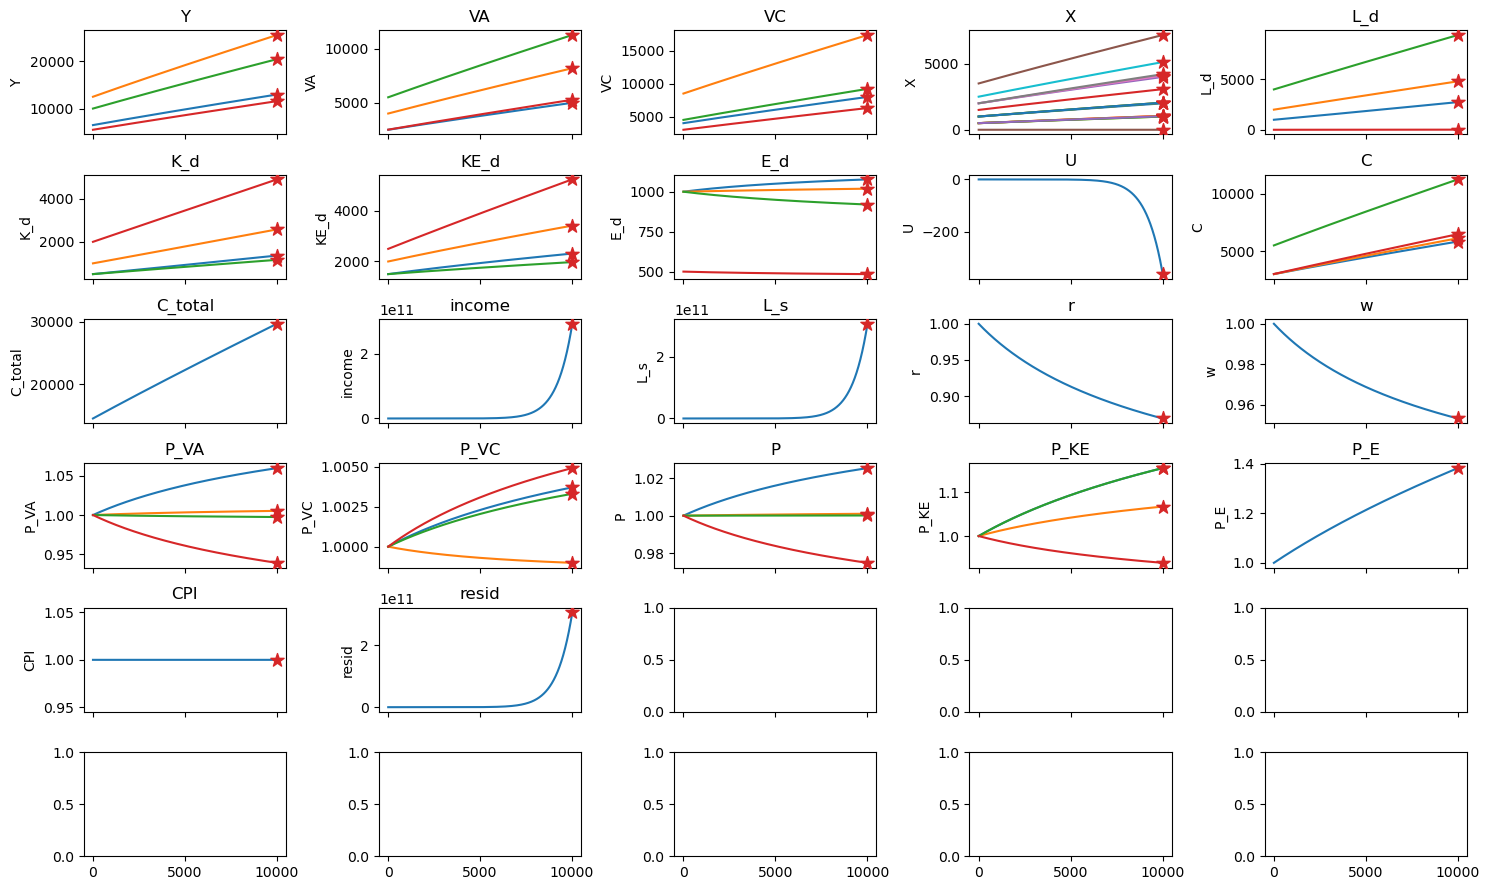

In [177]:
fig, ax = plt.subplots(6, 5, figsize=(15, 9), sharex=True)
for i, (axis, var) in enumerate(zip(fig.axes, mod.variable_names)):
    data = idata.variables[var]
    if data.ndim > 2:
        data = data.stack(pair=["i", "j"])
    data.plot.line(x="step", ax=axis, add_legend=False)
    axis.set(title=var, xlabel=None)

    scatter_grid = np.full(int(np.prod(res_d[var].shape)), idata.variables.coords["step"].max())
    axis.scatter(scatter_grid, res_d[var].ravel(), marker="*", color="tab:red", zorder=10, s=100)
fig.tight_layout()

In [138]:
calibrated_data["psi_X"]

array([[0.25      , 0.11764706, 0.22222222, 0.16666667],
       [0.5       , 0.41176471, 0.44444444, 0.66666667],
       [0.125     , 0.29411765, 0.22222222, 0.16666667],
       [0.125     , 0.17647059, 0.11111111, 0.        ]])